In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

### 使用在ImageNet数据集上预训练的ResNet-18模型来提取图像特征

In [2]:
# 加载了预训练的 ResNet-18 模型，并显示了模型的最后三个子模块。
pretrained_net=torchvision.models.resnet18(pretrained=True)
list(pretrained_net.children())[-3:]

C:\Users\eyrine\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\eyrine\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

In [3]:
#不要最后两层
net=nn.Sequential(*list(pretrained_net.children())[:-2])
                  
X = torch.rand(size=(1,3,320,480))
net(X).shape

torch.Size([1, 512, 10, 15])

### 使用1x1卷积层将输出通道数转换为PascalVOC2012数据集的类数（21类）。将要素地图的高宽和宽度增加32倍。

In [4]:
num_classes=21
net.add_module('final_conv',nn.Conv2d(512,num_classes,kernel_size=1))
net.add_module('transpose_conv',
               nn.ConvTranspose2d(
                   num_classes,num_classes,
                   kernel_size=64,padding=16,
                   stride=32))

### 初始化转置卷积层

双线性插值（bilinear interpolation） 是常用的上采样方法之一，它也经常用于初始化转置卷积层。
为了解释双线性插值，假设给定输入图像，我们想要计算上采样输出图像上的每个像素。

1.将输出图像的坐标(x,y)映射到输入图像的坐标(x',y')上。 例如，根据输入与输出的尺寸之比来映射。 请注意，映射后的x'和y'是实数。
2.在输入图像上找到离坐标(x',y')最近的4个像素。
3.输出图像在坐标(x,y)上的像素依据输入图像上这4个像素及其与(x',y')的相对距离来计算。

双线性插值的上采样可以通过转置卷积层实现，内核由以下bilinear_kernel函数构造。

In [5]:
def bilinear_kernel(in_channels,out_channels,kernel_size):
    # 计算中心点
    # 计算卷积核的中心位置，对于奇数大小的卷积核，中心是一个像素；对于偶数大小的卷积核，中心在两个像素之间
    factor=(kernel_size+1)//2
    if kernel_size%2==1:
        center=factor-1
    else:
        center=factor-0.5
    # 生成滤波器
    # 使用torch.arange创建了一个坐标网格og，然后计算了双线性插值滤波器filt。
    # 该滤波器的每个元素表示在该位置的权重，通过计算距离中心的相对位置来获得
    og=(torch.arange(kernel_size).reshape(-1,1),
        torch.arange(kernel_size).reshape(1,-1))
    filt=(1-torch.abs(og[0]-center)/factor)*\
         (1-torch.abs(og[1]-center)/factor)
    #创建一个形状为 (in_channels, out_channels, kernel_size, kernel_size) 
    #的权重张量，并将生成的滤波器填充到权重张量中。
    weight=torch.zeros((in_channels,out_channels,
                        kernel_size,kernel_size))
    weight=torch.zeros((in_channels,out_channels,
                        kernel_size,kernel_size))
    weight[range(in_channels),range(out_channels),:,:]=filt
    return weight;

In [6]:
#我们构造一个将输入的高和宽放大2倍的转置卷积层，并将其卷积核用bilinear_kernel函数初始化。
conv_trans=nn.ConvTranspose2d(3,3,kernel_size=4,padding=1,stride=2,
                              bias=False)
conv_trans.weight.data.copy_(bilinear_kernel(3,3,4));

In [7]:
img = torchvision.transforms.ToTensor()(d2l.Image.open('t01174fd3282cdbe5e3.jpg'))
X = img.unsqueeze(0)
Y = conv_trans(X)
out_img = Y[0].permute(1, 2, 0).detach()

input image shape: torch.Size([2592, 1944, 3])
output image shape: torch.Size([5184, 3888, 3])


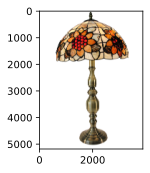

In [8]:
d2l.set_figsize()
print('input image shape:', img.permute(1, 2, 0).shape)
d2l.plt.imshow(img.permute(1, 2, 0));
print('output image shape:', out_img.shape)
d2l.plt.imshow(out_img);

In [9]:
W = bilinear_kernel(num_classes, num_classes, 64)
net.transpose_conv.weight.data.copy_(W);

In [10]:
batch_size, crop_size = 32, (320, 480)
train_iter, test_iter = d2l.load_data_voc(batch_size, crop_size)

read 1114 examples
read 1078 examples


loss 0.414, train acc 0.871, test acc 0.850
93.0 examples/sec on [device(type='cuda', index=0)]


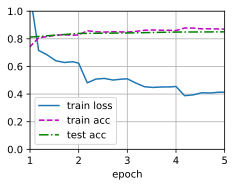

In [11]:
def loss(inputs, targets):
    return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)

num_epochs, lr, wd, devices = 5, 0.001, 1e-3, d2l.try_all_gpus()
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [12]:
def predict(img):
    X = test_iter.dataset.normalize_image(img).unsqueeze(0)
    pred = net(X.to(devices[0])).argmax(dim=1)
    return pred.reshape(pred.shape[1], pred.shape[2])

In [13]:
def label2image(pred):
    colormap = torch.tensor(d2l.VOC_COLORMAP, device=devices[0])
    X = pred.long()
    return colormap[X, :]

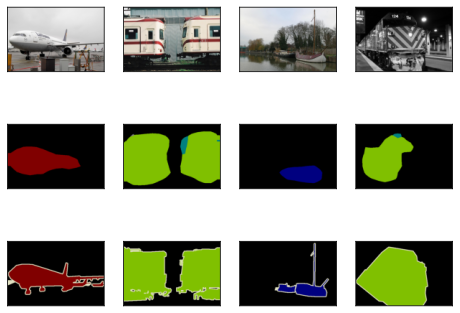

In [14]:
voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')
test_images, test_labels = d2l.read_voc_images(voc_dir, False)
n, imgs = 4, []
for i in range(n):
    crop_rect = (0, 0, 320, 480)
    X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    imgs += [X.permute(1,2,0), pred.cpu(),
             torchvision.transforms.functional.crop(
                 test_labels[i], *crop_rect).permute(1,2,0)]
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2);